# AUSTRALIA PRECIPITATION FORECASTS

### 1. DATA PREPROCESSING AND EXPLORATORY ANALYSIS


In [81]:
#pip install scikit-learn-intelex
import sklearnex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import mahalanobis

In [82]:
from sklearnex import patch_sklearn
patch_sklearn("SVC", "GridSearchCV", "cross_val_score")

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [83]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score

#### 1.1 DATA UPLOADING

In [84]:
data_o = pd.read_csv('weatherAUS.csv', delimiter=";", decimal=",", parse_dates=['Date'])
data = data_o.copy()
data.shape
#9999 observations
#23 variables

(9999, 23)

In [85]:
data.dtypes
#1  date
#6  categorical variables
#16 numerical variables

Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation             float64
Sunshine                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday                object
RainTomorrow             object
dtype: object

In [86]:
data.head()
#each row contains info about today's weather + whether it really rained the next day

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2010-12-07,Woomera,5.8,19.6,0.0,3.2,4.6,NNE,48.0,NE,...,58.0,34.0,1019.8,1014.0,7.0,7.0,9.5,18.6,No,Yes
1,2016-01-25,SydneyAirport,21.1,25.0,0.0,4.6,0.0,NE,35.0,S,...,85.0,67.0,1014.5,1013.3,8.0,8.0,22.3,24.3,No,Yes
2,2013-03-27,Cairns,23.8,30.9,2.8,5.2,5.0,SE,43.0,S,...,83.0,69.0,1013.1,1010.4,6.0,7.0,26.3,27.7,Yes,Yes
3,2012-04-20,NorfolkIsland,17.9,23.2,1.0,6.8,7.1,E,59.0,E,...,64.0,64.0,1026.0,1023.9,7.0,7.0,20.8,21.3,No,Yes
4,2010-10-05,Portland,10.4,20.7,0.4,2.0,7.5,NNW,52.0,N,...,74.0,59.0,1011.6,1006.5,2.0,7.0,14.5,19.6,No,Yes


#### 1.2 VARIABLES CONGRUNCE CHECK

In [87]:
round(data.describe(), 2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00
mean,13.46,24.14,2.12,5.45,7.71,40.83,15.69,19.80,66.28,49.79,1017.39,1014.95,4.25,4.35,18.14,22.64
std,6.44,7.01,6.87,3.71,3.75,13.34,8.28,8.58,18.42,20.00,7.01,6.96,2.79,2.64,6.62,6.86
min,-6.70,7.00,0.00,0.00,0.00,11.00,2.00,2.00,4.00,1.00,982.20,981.40,0.00,0.00,-0.70,5.10
25%,8.50,18.60,0.00,2.80,5.00,31.00,9.00,13.00,56.00,36.00,1012.80,1010.10,1.00,2.00,13.00,17.20
50%,13.20,23.80,0.00,4.80,8.60,39.00,15.00,19.00,67.00,51.00,1017.20,1014.80,5.00,5.00,17.70,22.30
75%,18.40,29.70,0.60,7.40,10.70,48.00,20.00,26.00,79.00,63.00,1022.10,1019.60,7.00,7.00,23.20,27.90
max,30.50,46.80,113.00,65.40,14.30,107.00,67.00,65.00,100.00,100.00,1040.40,1038.90,8.00,9.00,37.20,46.10


In [88]:
print(sum(data['MinTemp']>data['MaxTemp']),   #Is daily max temp always greater than the minimum one? --> YES
      sum(data['MinTemp']>data['Temp9am']),   #Is daily min temp always smaller than the one at 9 am? --> YES
      sum(data['MinTemp']>data['Temp3pm']),   #Is daily min temp always smaller than the one at 3 pm? --> NO
      sum(data['MaxTemp']<data['Temp9am']),   #Is daily max temp always greater than the one at 9 am? --> YES
      sum(data['MaxTemp']<data['Temp3pm']))   #Is daily max temp always greater than the one at 3 pm? --> YES 

0 0 89 0 0


In [89]:
#Given the absence of additional metadata the records with incongruent values are removed.
data=data[data['MinTemp']<=data['Temp3pm']]
data.reset_index(drop=True, inplace=True)
data
#9999 - 89 = 9910 observations
#23 variables

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2010-12-07,Woomera,5.8,19.6,0.0,3.2,4.6,NNE,48.0,NE,...,58.0,34.0,1019.8,1014.0,7.0,7.0,9.5,18.6,No,Yes
1,2016-01-25,SydneyAirport,21.1,25.0,0.0,4.6,0.0,NE,35.0,S,...,85.0,67.0,1014.5,1013.3,8.0,8.0,22.3,24.3,No,Yes
2,2013-03-27,Cairns,23.8,30.9,2.8,5.2,5.0,SE,43.0,S,...,83.0,69.0,1013.1,1010.4,6.0,7.0,26.3,27.7,Yes,Yes
3,2012-04-20,NorfolkIsland,17.9,23.2,1.0,6.8,7.1,E,59.0,E,...,64.0,64.0,1026.0,1023.9,7.0,7.0,20.8,21.3,No,Yes
4,2010-10-05,Portland,10.4,20.7,0.4,2.0,7.5,NNW,52.0,N,...,74.0,59.0,1011.6,1006.5,2.0,7.0,14.5,19.6,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,2011-01-16,CoffsHarbour,17.2,27.0,0.0,5.4,11.4,SSE,26.0,SW,...,71.0,67.0,1009.2,1006.8,1.0,1.0,24.4,26.3,No,No
9906,2012-11-17,Sydney,15.1,21.3,10.4,2.4,7.0,SE,33.0,ESE,...,57.0,50.0,1016.7,1015.1,8.0,4.0,17.4,19.8,Yes,No
9907,2009-07-07,PerthAirport,7.9,17.7,4.0,1.8,2.0,WNW,28.0,NE,...,88.0,55.0,1017.9,1016.7,6.0,7.0,12.0,17.3,Yes,No
9908,2014-09-23,Perth,6.5,17.1,0.0,4.0,0.0,SSE,17.0,ENE,...,65.0,58.0,1027.5,1025.2,8.0,8.0,12.9,16.7,No,No


In [90]:
round(data.describe(), 2)
#Rainfall, evaporation, sunshine, wind speed, humidity, pressure and cloud always take non negative values (min >=0).

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00,9910.00
mean,13.41,24.16,2.10,5.44,7.76,40.72,15.66,19.78,66.21,49.48,1017.45,1014.99,4.22,4.33,18.12,22.69
std,6.44,7.02,6.86,3.71,3.72,13.27,8.28,8.56,18.42,19.78,6.98,6.95,2.79,2.63,6.62,6.85
min,-6.70,7.00,0.00,0.00,0.00,11.00,2.00,2.00,4.00,1.00,984.60,981.40,0.00,0.00,-0.70,5.10
25%,8.50,18.60,0.00,2.80,5.10,31.00,9.00,13.00,55.25,36.00,1012.90,1010.20,1.00,2.00,12.90,17.30
50%,13.10,23.90,0.00,4.80,8.70,39.00,15.00,19.00,67.00,50.00,1017.30,1014.80,5.00,5.00,17.70,22.40
75%,18.30,29.70,0.60,7.40,10.70,48.00,20.00,26.00,79.00,63.00,1022.10,1019.70,7.00,7.00,23.20,27.90
max,30.50,46.80,113.00,65.40,14.30,107.00,67.00,65.00,100.00,100.00,1040.40,1038.90,8.00,9.00,37.20,46.10


#### 1.3 VARIABLE "SEASON" CREATION

In [91]:
#We are assuming that whether tomorrow will rain likely depends only on today's weather. 
#Instead of the date it is possible to derive a (presumably) more informative variable: the season. 

df = pd.DataFrame({'Month': data['Date'].dt.month, 'Day': data['Date'].dt.day})
for j,r in df.iterrows():
    if (r['Month'] in [4, 5]) or (r['Month'] == 3 and r['Day'] >= 21) or (r['Month'] == 6 and r['Day'] <= 21):
        data.loc[j,'Season']='Autumn'        #21/03 - 21/06 --> Autumn
    elif (r['Month'] in [7, 8]) or (r['Month'] == 6 and r['Day'] >= 22) or (r['Month'] == 9 and r['Day'] <= 22):
        data.loc[j,'Season']='Winter'        #22/06 - 22/09 --> Winter
    elif (r['Month'] in [10, 11]) or (r['Month'] == 9 and r['Day'] >= 23) or (r['Month'] == 12 and r['Day'] <= 21):
        data.loc[j,'Season']='Spring'        #23/09 - 21/12 --> Spring
    else:
        data.loc[j,'Season']='Summer'
del(df)

In [92]:
data=data.drop('Date', axis=1)
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Season
0,Woomera,5.8,19.6,0.0,3.2,4.6,NNE,48.0,NE,N,...,34.0,1019.8,1014.0,7.0,7.0,9.5,18.6,No,Yes,Spring
1,SydneyAirport,21.1,25.0,0.0,4.6,0.0,NE,35.0,S,ENE,...,67.0,1014.5,1013.3,8.0,8.0,22.3,24.3,No,Yes,Summer
2,Cairns,23.8,30.9,2.8,5.2,5.0,SE,43.0,S,S,...,69.0,1013.1,1010.4,6.0,7.0,26.3,27.7,Yes,Yes,Autumn
3,NorfolkIsland,17.9,23.2,1.0,6.8,7.1,E,59.0,E,E,...,64.0,1026.0,1023.9,7.0,7.0,20.8,21.3,No,Yes,Autumn
4,Portland,10.4,20.7,0.4,2.0,7.5,NNW,52.0,N,NNW,...,59.0,1011.6,1006.5,2.0,7.0,14.5,19.6,No,Yes,Spring


#### 1.4 VARIABLE "CLIMATE" CREATION

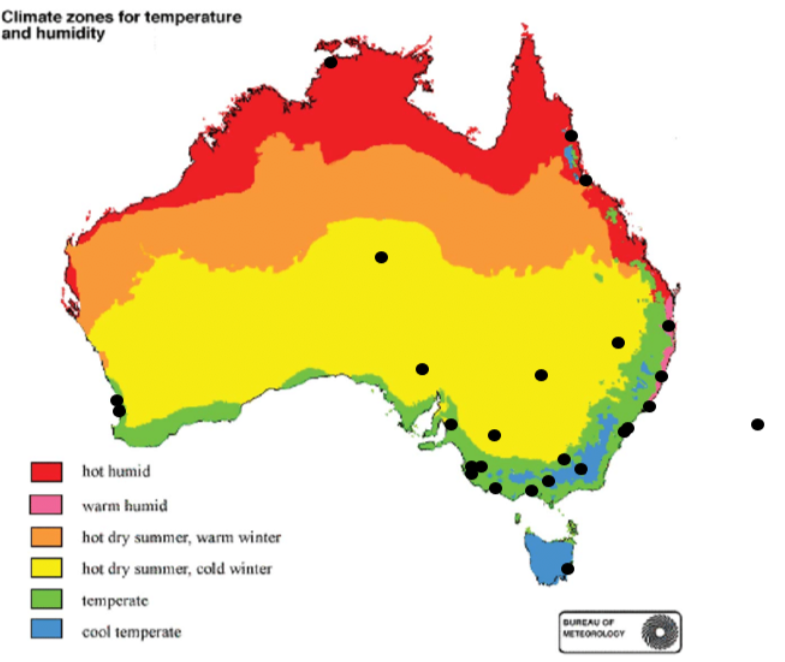

In [93]:
def climate(x):
    if x['Location'] in ["Canberra", "Townsville", "Sale", "WaggaWagga"]:
        return "Cool Temperate"
    elif x['Location'] in ["Melbourne", "MelbourneAirport", "Hobart", "Brisbane", "Perth", "PerthAirport","MountGambier", "Sydney",
                           "SydneyAirport", "Watsonia", "Williamtown", "CoffsHarbour", "Portland", "Nuriootpa"]:
        return "Temperate"
    elif x['Location'] in ["Cobar","Woomera","AliceSprings","Moree", "Mildura"]:
        return "Arid"
    else:
        return "Tropical/Subtropical"
    
data['Climate'] = data.apply(climate, axis=1)

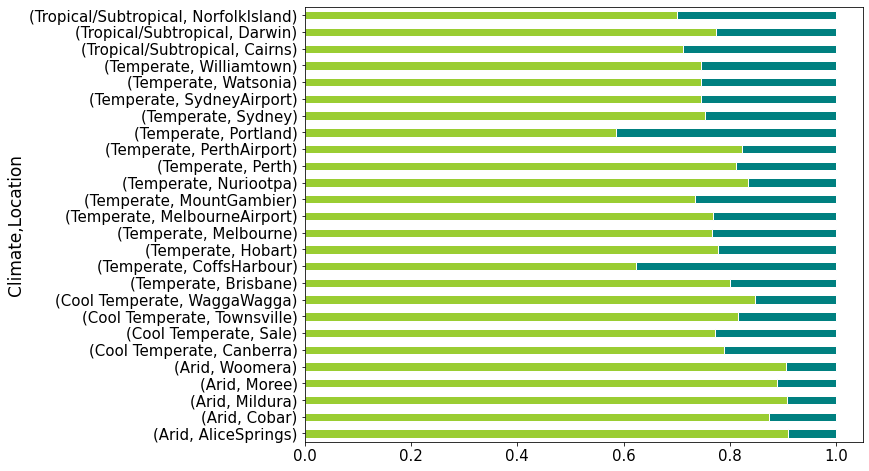

In [94]:
pd.crosstab([data['Climate'], data['Location']], data['RainTomorrow'], normalize="index").plot(kind='barh', stacked=True, grid=False, edgecolor='w', color=['yellowgreen','teal'], figsize=(10, 8)) 
plt.legend().remove()
data=data.drop("Location", axis=1)
#Locations belonging to the same climate zone seem to have similar percentages of rainy days.

#### 1.5 GRAPHICAL EXPLORATION OF THE DISCRIMINANT POWER OF EACH  CATEGORICAL VARIABLE

Text(0, 0.5, '')

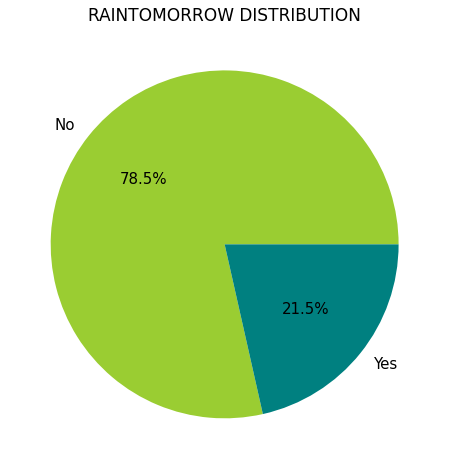

In [95]:
data['RainTomorrow'].value_counts().plot.pie(colors=['yellowgreen','teal'], figsize=(10, 8), autopct='%1.1f%%', fontsize=15)
plt.title("RAINTOMORROW DISTRIBUTION", fontsize=17)
plt.ylabel('')

In [96]:
xquant=data.select_dtypes(include=['float64']).columns
xcateg=data.loc[:, data.columns != 'RainTomorrow'].select_dtypes(include=['object']).columns

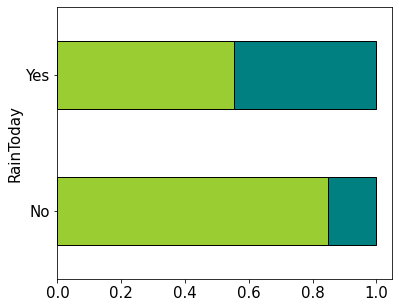

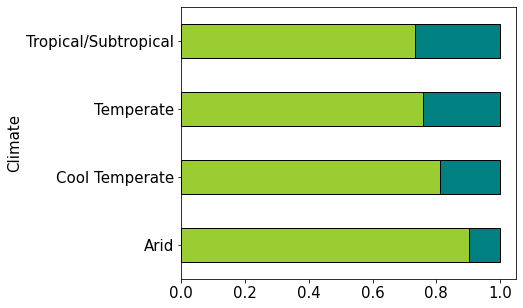

In [97]:
#Not cyclic categorical variables

plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)
for i in ["RainToday", "Climate"]:
    pd.crosstab(data.loc[:, i], data['RainTomorrow'],normalize="index").plot(kind='barh', stacked=True, grid=False, 
                                                                             edgecolor='black', color=['yellowgreen','teal'],figsize=(6, 5))
    plt.legend().remove()

In [98]:
#Cyclic categorical variables

#pip install pygal
import pygal
from pygal.style import Style

for i in ["WindGustDir", "WindDir9am", "WindDir3pm", "Season"]:
    # compute the frequency distribution of the column
    if i == "Season": 
        sortedid = ["Spring", "Winter", "Autumn","Summer"]
    else: 
        sortedid = ["N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S",
                    "SSE", "SE", "ESE", "E", "ENE", "NE", "NNE"]
    
    freq = pd.crosstab(index=data[i], columns=data['RainTomorrow'], normalize='index').reindex(sortedid)
    # create a radar chart
    chart = pygal.Radar(style=Style(label_font_size=14))
    chart.title = f'CONDITIONAL DISTRIBUTION OF RainTomorrow | {i} '
    chart.x_labels = freq.index
    chart.add('RainTomorrow:Yes', freq['Yes'])
    chart.add('RainTomorrow:No', freq['No'])
    chart.range = (0, 1)
    chart.render_in_browser()
    #chart.render_to_file('radar_chart.svg')

file://C:/Users/giuli/AppData/Local/Temp/tmpkyowxkpi.html
file://C:/Users/giuli/AppData/Local/Temp/tmpqemidns2.html
file://C:/Users/giuli/AppData/Local/Temp/tmpioxljujk.html
file://C:/Users/giuli/AppData/Local/Temp/tmpqbq_nje5.html


#### 1.6 GRAPHICAL EXPLORATION OF THE DISCRIMINANT POWER OF EACH  NUMERICAL VARIABLE

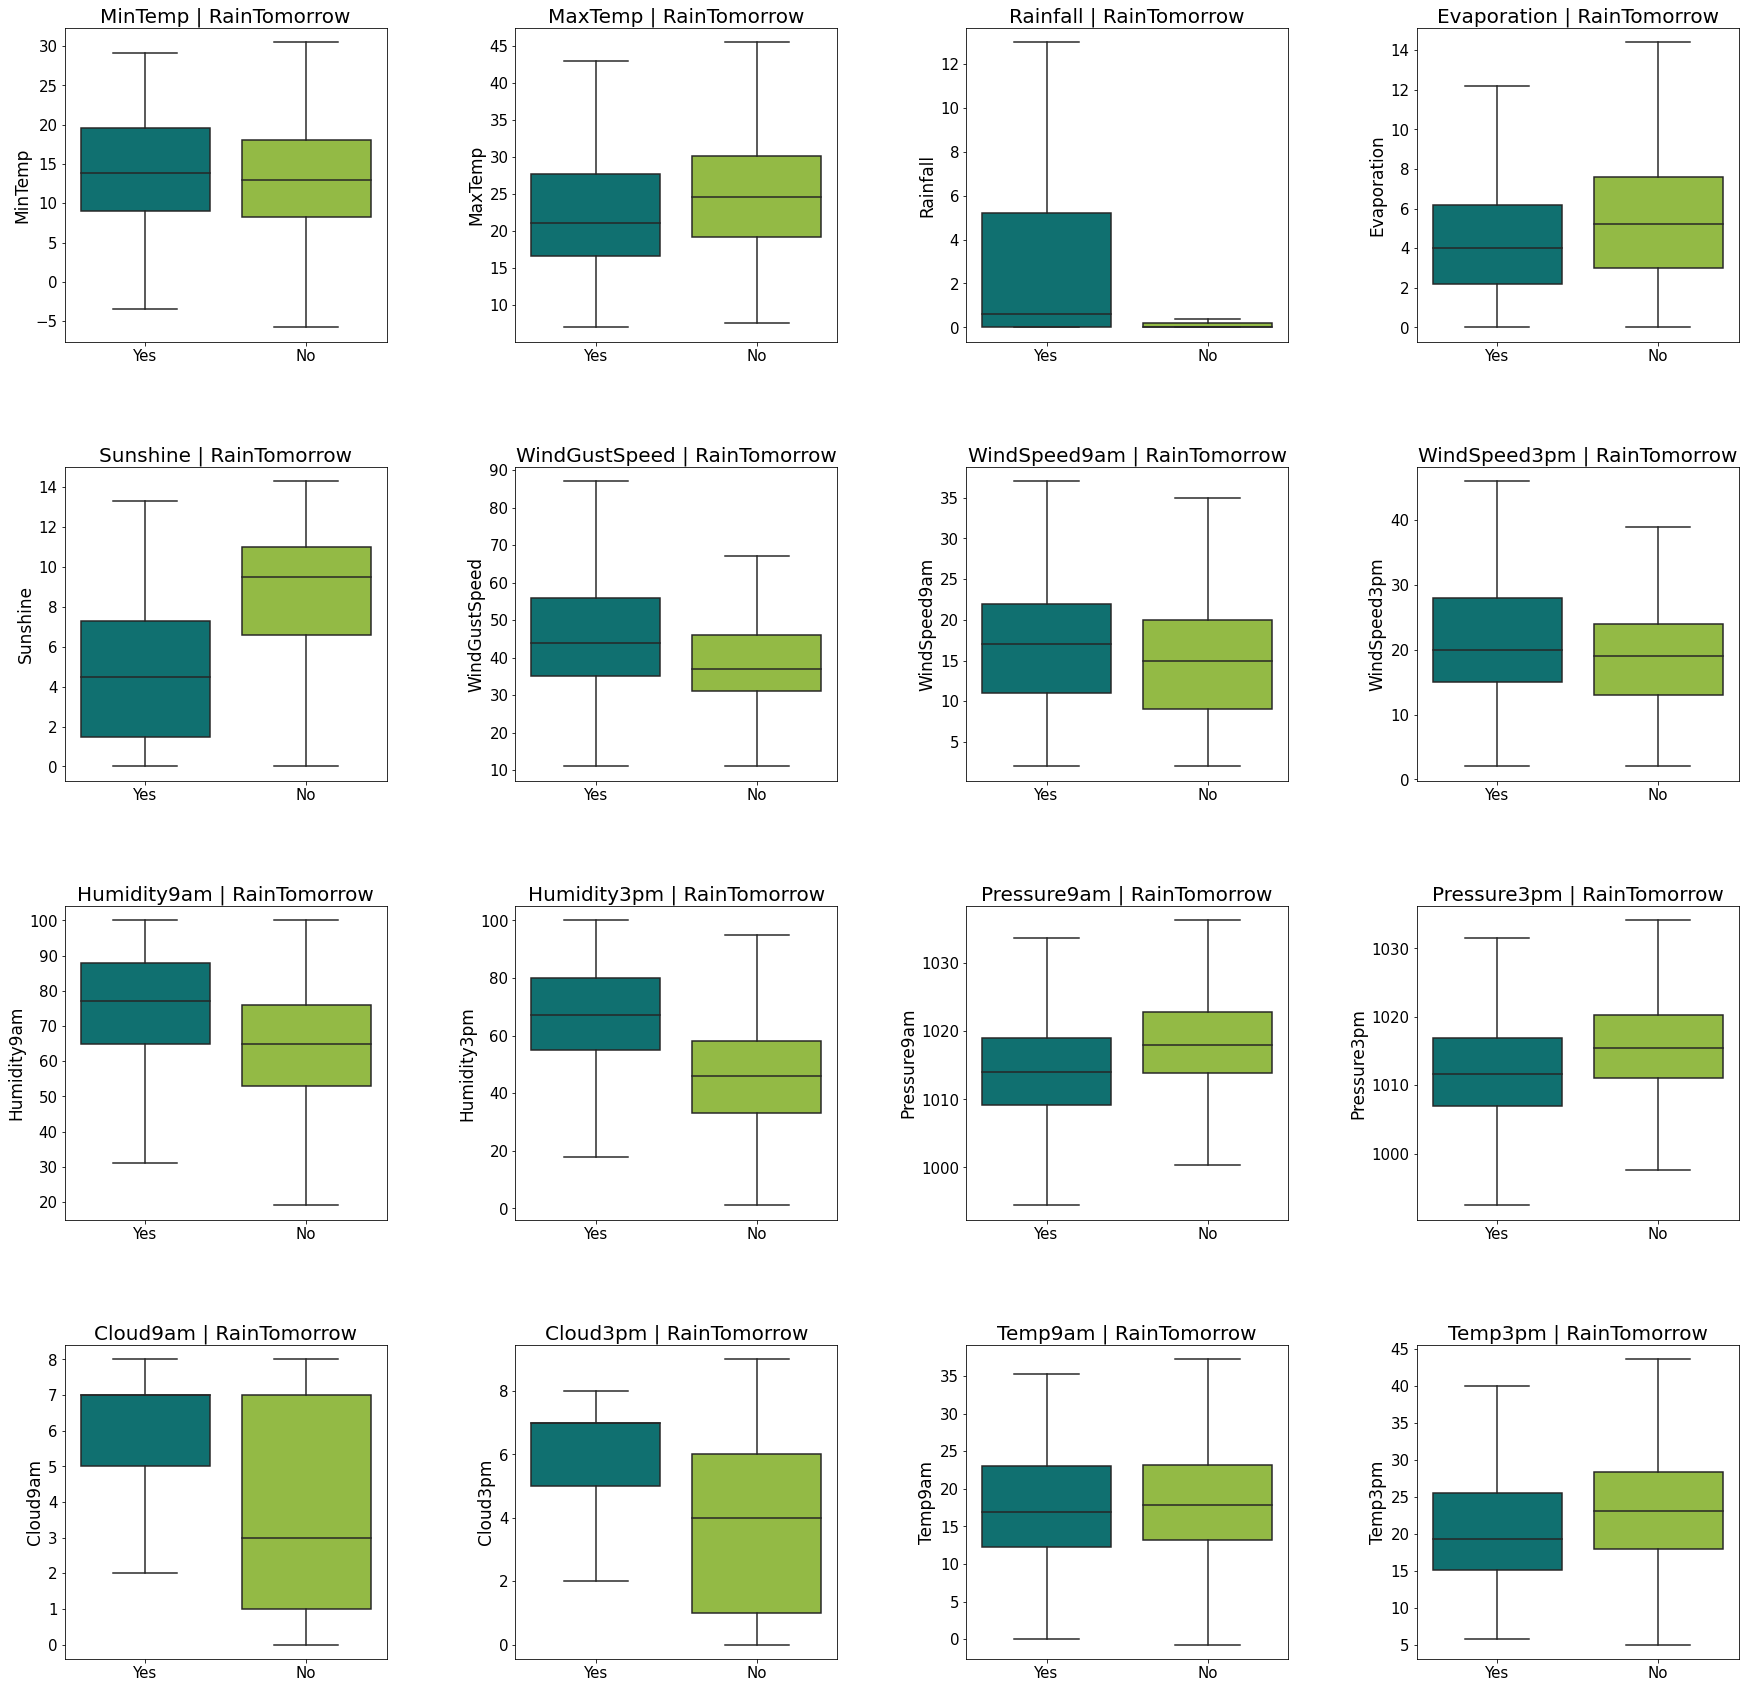

In [99]:
#To highlight differences outliers are temporarily removed.
plt.figure(figsize=(30, 30))
plt.rc('axes', labelsize=17)

for i, colonna in enumerate(data.select_dtypes(include=['float64']).columns, start=1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='RainTomorrow',  y=colonna, data=data, showfliers=False, palette=['teal', 'yellowgreen'])
    plt.title(f"{colonna} | RainTomorrow", fontsize=20)
    plt.xlabel('')
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

#### 1.7 DUMMY VARIABLES ENCODING AND STANDARDIZATION

In [100]:
#1 DUMMY VARIABLE FOR EACH VALUE OF EACH CATEGORICAL VAWRIABLE
for x in xcateg:
    for value in data[x].unique():
        data[str(value)] = np.where(data[x] == value, 1, 0) 
    data=data.drop(x, axis=1)
data.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainTomorrow', 'NNE', 'NE', 'SE', 'E', 'NNW',
       'SSW', 'WSW', 'ESE', 'S', 'WNW', 'W', 'NW', 'SSE', 'N', 'SW', 'ENE',
       'No', 'Yes', 'Spring', 'Summer', 'Autumn', 'Winter', 'Arid',
       'Temperate', 'Tropical/Subtropical', 'Cool Temperate'],
      dtype='object')

In [101]:
#STANDARDIZATION OF THE NUMERICAL VARIABLES
scaler = StandardScaler()
data[xquant.tolist()] = scaler.fit_transform(data[xquant.tolist()])
data

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,No,Yes,Spring,Summer,Autumn,Winter,Arid,Temperate,Tropical/Subtropical,Cool Temperate
0,-1.183125,-0.650425,-0.305812,-0.603707,-0.849098,0.548777,0.162386,1.310625,-0.445782,-0.782387,...,1,0,1,0,0,0,1,0,0,0
1,1.194390,0.119153,-0.305812,-0.226332,-2.084868,-0.430785,0.162386,-0.324989,1.020287,0.885979,...,1,0,0,1,0,0,0,1,0,0
2,1.613952,0.959988,0.102290,-0.064600,-0.741640,0.172022,-0.079297,-0.558648,0.911690,0.987092,...,0,1,0,0,1,0,0,0,1,0
3,0.697132,-0.137373,-0.160061,0.366685,-0.177485,1.377637,1.854166,2.712579,-0.119989,0.734310,...,1,0,0,0,1,0,0,0,1,0
4,-0.468317,-0.493659,-0.247511,-0.927170,-0.070027,0.850181,0.766593,0.726477,0.423000,0.481527,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,0.588357,0.404182,-0.305812,-0.010690,0.977690,-1.108944,-0.320980,-0.324989,0.260103,0.885979,...,1,0,0,1,0,0,0,1,0,0
9906,0.262031,-0.408151,1.209995,-0.819349,-0.204349,-0.581487,-0.320980,-0.558648,-0.500081,0.026518,...,0,1,1,0,0,0,0,1,0,0
9907,-0.856800,-0.921203,0.277191,-0.981081,-1.547577,-0.958242,-0.804346,-0.558648,1.183184,0.279301,...,0,1,0,0,0,1,0,1,0,0
9908,-1.074350,-1.006712,-0.305812,-0.388064,-2.084868,-1.787103,-1.408553,-1.259625,-0.065690,0.430970,...,1,0,1,0,0,0,0,1,0,0


#### 1.8 MULTIVARIATE OUTLIERS DETECTION

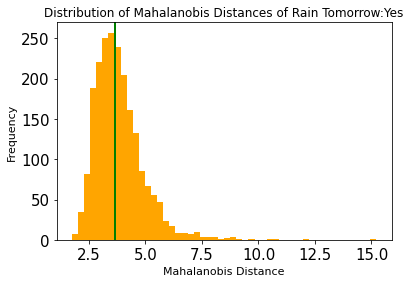

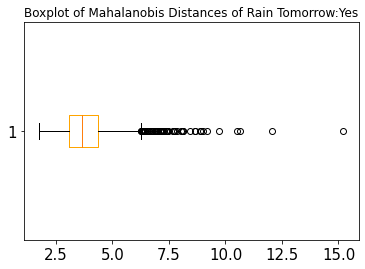

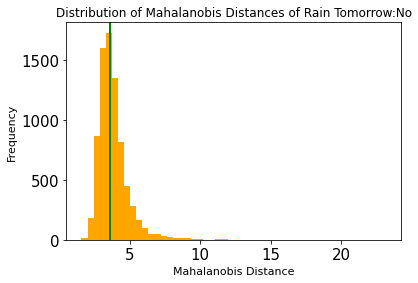

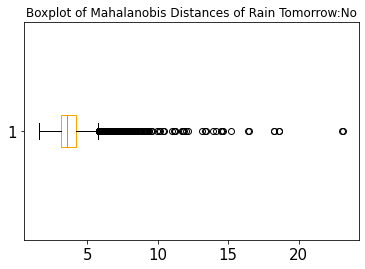

In [102]:
md = {}

for j in ["Yes","No"]:    
    VI = data[data['RainTomorrow']==j][xquant].cov().values      #covariance matrix
    VIt = np.linalg.inv(VI)             #its inverse
    md_list = []
    
    #For each observation we compute the mh distance from the centroid (point of covariate = means)
    for i in range(len(data[data['RainTomorrow']==j][xquant])):
        md_list.append(mahalanobis(data[data['RainTomorrow']==j][xquant].iloc[i], data[data['RainTomorrow']==j][xquant].mean(), VIt))
    md[str(j)]=md_list
    
    #Plot the distribution of Mahalanobis distances
    plt.hist(md_list, bins=50, color='orange')
    plt.title(f"Distribution of Mahalanobis Distances of Rain Tomorrow:{j}" )
    plt.xlabel('Mahalanobis Distance', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.axvline(np.median(md_list), color='green', linestyle='-', linewidth=2)
    plt.show()

    plt.boxplot(md_list, vert=False, boxprops=dict(color='orange'))
    plt.title(f"Boxplot of Mahalanobis Distances of Rain Tomorrow:{j}" )
    plt.show()

In [103]:
#DESCRIPTIVE STATISTICS OF THE DISTANCES -> Yes 
removeyes=pd.DataFrame.from_dict(md["Yes"]).describe()[0][6]*1.5
pd.DataFrame.from_dict(md["Yes"]).describe()

,0
count,2128.000000
mean,3.842543
std,1.108115
min,1.748474
25%,3.094487
50%,3.656475
75%,4.362397
max,15.212946


In [104]:
#DESCRIPTIVE STATISTICS OF THE DISTANCES -> No
removeno=pd.DataFrame.from_dict(md["No"]).describe()[0][6]*1.5
pd.DataFrame.from_dict(md["No"]).describe()

,0
count,7782.000000
mean,3.813439
std,1.206570
min,1.566071
25%,3.128151
50%,3.581283
75%,4.195978
max,23.176613


In [105]:
indexesYes = [index for index in range(len(md[str("Yes")]))
           if md[str("Yes")][index] > removeyes]
indexesNo = [index for index in range(len(md[str("No")]))
           if md[str("No")][index] > removeno]
indexes=indexesYes+indexesNo
len(indexesYes),len(indexesNo) #number of outliers

(50, 233)

### 2. ADAPTING A SVM CLASSIFIER WITH KERNELS
- LINEAR;
- POLYNOMIAL;
- RADIAL BASIS FUNCTION.

In [106]:
import time
import warnings
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=FutureWarning)
precision_No = make_scorer(precision_score, pos_label="No")

In [107]:
def optim_svm(X, Y, kernel_type, grid, K, k):
    t0=time.time()
        
    if kernel_type not in ["linear", "poly", "rbf"]:
        raise ValueError("Wrong kernel_type")
    
    outer_results = pd.DataFrame(columns=["Fold", *grid, "Inner Precision", "Outer Precision"])
    cv_outer = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)
    svm_model = SVC(kernel=kernel_type, random_state = 1)
    
    #In the 1st nesting level we split the data into K folds. In contrast with the original formulation of the cv, since the high number
    #of instances we are now considering at each iteration the i-th fold as training set and the remaning K-1 as validation. 
    for fold, (train_ix, test_ix) in enumerate(cv_outer.split(X, Y)):
        X_train, X_test = X[train_ix, :], X[test_ix, :]    
        y_train, y_test = Y[train_ix], Y[test_ix]
        
        #In the 2nd nesting level we split the i-th fold (identified by the loop id "fold") into k fold (usually k<=K).
        #On each sub-fold the parameters grid is adapted an evalueated using grid search as search algorithm.
        #The best parameters combination is that one that maximises the scoring function specified.
        cv_inner=StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        gridSearch = GridSearchCV(svm_model, grid, scoring=precision_No, cv=cv_inner, refit=True)
        searchResult = gridSearch.fit(X_train,y_train)
        best_params = gridSearch.best_params_  
        best_precision = gridSearch.best_score_

        #With respect to the i-th fold we get the best model i.e. the one with the "best_params". 
        best_model = searchResult.best_estimator_
        best_model.fit(X_train,y_train)

        #How well the best_model perform on the remaining K-1 folds not used to train it?
        y_predout = best_model.predict(X_test)
        
        #We save the results in a dataframe showing the i-th fold considered, the best model with tuned hyperparameters, 
        #its accuracy and the accuracy one the remaining K-1 folds.
        outer_results = outer_results.append(pd.Series([fold+1, 
                                                        *(list(best_params.values())), 
                                                        round(best_precision,3), 
                                                        round(metrics.precision_score(y_test, y_predout, pos_label='No'),3)],
                                               index=outer_results.columns), ignore_index=True)
                                                    
        
    return(outer_results, print('The mean precision in the outer loop is', round(outer_results["Outer Precision"].mean(),3)), print('The standard deviation of precision in the outer loop is', round(outer_results["Outer Precision"].std(),3)), print('Time taken:', time.time()-t0, 'sec')) 

### 2.1 NESTED CROSS VALIDATION ON THE ORIGINAL DATASET 

In [108]:
#data.dtypes
data1=data.copy()
X=data1.drop("RainTomorrow",axis=1)
y=data1["RainTomorrow"]

In [109]:
#TRAIN AND TEST SPLITTING
#test set and train set with (some) outliers
X_Nest,X_Sep,y_Nest,y_Sep=train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_Nest.shape, X_Sep.shape

((5946, 42), (3964, 42))

In [110]:
X_Nest1=X_Nest.loc[~X_Nest.index.isin(indexesYes) & ~X_Nest.index.isin(indexesNo)]
y_Nest1=y_Nest.loc[~y_Nest.index.isin(indexesYes) & ~y_Nest.index.isin(indexesNo)]
X_Nest1.shape #training set without outliers

(5780, 42)

In [112]:
#LINEAR KERNEL (with outliers) 
gridHyperPar_L = {'C': np.logspace(-5, -0.5, 10).tolist()} 
results_L, _, _,_ = optim_svm(X_Nest.values, y_Nest.values, kernel_type="linear", grid=gridHyperPar_L, K=10, k=5)
results_L

The mean precision in the outer loop is 0.868
The standard deviation of precision in the outer loop is 0.011
Time taken: 138.728600025177 sec


,Fold,C,Inner Precision,Outer Precision
0,1.0,0.100000,0.863,0.888
1,2.0,0.100000,0.871,0.859
2,3.0,0.316228,0.871,0.855
3,4.0,0.316228,0.870,0.872
4,5.0,0.316228,0.870,0.865
5,6.0,0.100000,0.864,0.875
6,7.0,0.100000,0.870,0.875
7,8.0,0.316228,0.869,0.880
8,9.0,0.316228,0.872,0.854
9,10.0,0.316228,0.870,0.860


In [113]:
#POLYNOMIAL KERNEL (with outliers) 
gridHyperPar_P = {'C': np.logspace(-5, -0.5, 5).tolist(), 'degree': range(2, 7)} 
results_P, _,  _, _ = optim_svm(X_Nest.values, y_Nest.values, kernel_type="poly", grid=gridHyperPar_P, K=10, k=5)
results_P

The mean precision in the outer loop is 0.855
The standard deviation of precision in the outer loop is 0.011
Time taken: 337.5127727985382 sec


,Fold,C,degree,Inner Precision,Outer Precision
0,1.0,0.316228,2.0,0.851,0.881
1,2.0,0.316228,2.0,0.856,0.842
2,3.0,0.316228,2.0,0.854,0.848
3,4.0,0.316228,2.0,0.854,0.857
4,5.0,0.316228,2.0,0.854,0.854
5,6.0,0.316228,2.0,0.852,0.857
6,7.0,0.316228,2.0,0.853,0.860
7,8.0,0.316228,2.0,0.852,0.858
8,9.0,0.316228,2.0,0.857,0.844
9,10.0,0.316228,2.0,0.855,0.851


In [115]:
#RADIAL BASIS FUNCTION KERNEL (with outliers)
gridHyperPar_R = {'C': np.logspace(-5, -0.5, 5).tolist(), 'gamma': np.logspace(-5, 2, 5).tolist()} 
results_R, _ , _ , _ = optim_svm(X_Nest.values, y_Nest.values, kernel_type="rbf", grid=gridHyperPar_R, K=10, k=5)
results_R

The mean precision in the outer loop is 0.857
The standard deviation of precision in the outer loop is 0.012
Time taken: 328.79807591438293 sec


,Fold,C,gamma,Inner Precision,Outer Precision
0,1.0,0.316228,0.031623,0.853,0.879
1,2.0,0.316228,0.031623,0.857,0.852
2,3.0,0.316228,0.031623,0.858,0.845
3,4.0,0.316228,0.031623,0.859,0.858
4,5.0,0.316228,0.031623,0.857,0.854
5,6.0,0.316228,0.031623,0.855,0.863
6,7.0,0.316228,0.031623,0.858,0.864
7,8.0,0.316228,0.031623,0.855,0.871
8,9.0,0.316228,0.031623,0.860,0.837
9,10.0,0.316228,0.031623,0.858,0.851


### 2.2 NESTED CROSS VALIDATION ON THE DATASET WITHOUT OUTLIERS  

In [114]:
#LINEAR KERNEL (without outliers) 
results_L1, _, _ , _= optim_svm(X_Nest1.values, y_Nest1.values, kernel_type="linear", grid=gridHyperPar_L, K=10, k=5)
results_L1

The mean precision in the outer loop is 0.871
The standard deviation of precision in the outer loop is 0.008
Time taken: 130.1121747493744 sec


,Fold,C,Inner Precision,Outer Precision
0,1.0,0.100000,0.872,0.877
1,2.0,0.316228,0.871,0.870
2,3.0,0.316228,0.867,0.887
3,4.0,0.031623,0.871,0.862
4,5.0,0.316228,0.874,0.871
5,6.0,0.316228,0.870,0.872
6,7.0,0.100000,0.870,0.877
7,8.0,0.316228,0.872,0.868
8,9.0,0.316228,0.871,0.865
9,10.0,0.316228,0.873,0.862


In [117]:
#POLYNOMIAL KERNEL (without outliers) 
results_P1, _,  _ , _ = optim_svm(X_Nest1.values, y_Nest1.values, kernel_type="poly", grid=gridHyperPar_P, K=10, k=5)
results_P1

The mean precision in the outer loop is 0.858
The standard deviation of precision in the outer loop is 0.007
Time taken: 334.380268573761 sec


,Fold,C,degree,Inner Precision,Outer Precision
0,1.0,0.316228,2.0,0.858,0.859
1,2.0,0.316228,2.0,0.856,0.857
2,3.0,0.316228,2.0,0.854,0.875
3,4.0,0.316228,2.0,0.857,0.853
4,5.0,0.316228,2.0,0.857,0.857
5,6.0,0.316228,2.0,0.857,0.858
6,7.0,0.316228,2.0,0.856,0.861
7,8.0,0.316228,2.0,0.856,0.854
8,9.0,0.316228,2.0,0.856,0.852
9,10.0,0.316228,2.0,0.856,0.856


In [118]:
#RADIAL BASIS FUNCTION KERNEL (without outliers) 
results_R1, _ , _ , _ = optim_svm(X_Nest1.values, y_Nest1.values, kernel_type="rbf", grid=gridHyperPar_R, K=10, k=5)
results_R1

The mean precision in the outer loop is 0.861
The standard deviation of precision in the outer loop is 0.008
Time taken: 342.2454149723053 sec


,Fold,C,gamma,Inner Precision,Outer Precision
0,1.0,0.316228,0.031623,0.863,0.864
1,2.0,0.316228,0.031623,0.858,0.859
2,3.0,0.316228,0.031623,0.854,0.882
3,4.0,0.316228,0.031623,0.858,0.852
4,5.0,0.316228,0.031623,0.859,0.862
5,6.0,0.316228,0.031623,0.858,0.856
6,7.0,0.316228,0.031623,0.860,0.862
7,8.0,0.316228,0.031623,0.860,0.857
8,9.0,0.316228,0.031623,0.858,0.854
9,10.0,0.316228,0.031623,0.860,0.858


### 2.3 CONFUSION MATRICES

#### ORIGINAL DATASET 

In [119]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [120]:
#SELECTED MODEL (training set with outliers)
modell1=SVC(kernel="linear", C=0.316228)
modell1.fit(X_Nest, y_Nest)
y_pred1=modell1.predict(X_Sep)

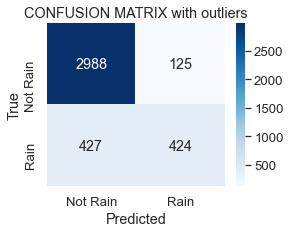

In [121]:
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix(y_Sep,y_pred1), annot=True, fmt='g', cmap='Blues', xticklabels=['Not Rain', 'Rain'], yticklabels=['Not Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CONFUSION MATRIX with outliers')
plt.show()

In [122]:
#PRECISION NOT RAIN, PRECISION RAIN, ACCURACY
round(precision_score(y_Sep,y_pred1, pos_label='No'),3),round(precision_score(y_Sep,y_pred1,pos_label="Yes"),3),round(accuracy_score(y_Sep,y_pred1),3)

(0.875, 0.772, 0.861)

In [123]:
#HYPERPLANE COEFFICIENTS FOR EACH VARIABLE
modell1.coef_

array([[-5.72610334e-02,  2.48254287e-01, -1.07174366e-02,
         8.16598633e-02, -3.14875207e-01,  5.58028748e-01,
        -8.79374157e-03, -2.42501500e-01, -4.14242389e-02,
         9.29970446e-01,  4.76470102e-01, -7.37612637e-01,
        -1.23878286e-01,  5.05040193e-02, -2.28206535e-01,
         6.72435711e-02, -2.34082277e-01, -7.55902819e-02,
        -1.02679216e-02, -6.01062680e-02,  1.09683257e-01,
         1.14754899e-01, -3.11276426e-02, -7.05370225e-02,
        -2.01662695e-01,  3.68727832e-02,  3.52990909e-01,
         2.93897234e-01,  1.97563630e-03,  9.97411732e-02,
        -1.98979165e-01, -1.27562617e-01, -1.55246233e-01,
         1.55246233e-01,  1.70346779e-02,  2.05379708e-02,
        -1.63384192e-02, -2.12342295e-02,  9.17570856e-04,
         1.00567779e-01, -4.07760461e-02, -6.07093038e-02]])

Text(0.5, 1.0, 'Linear SVM weights with outliers')

<Figure size 576x432 with 0 Axes>

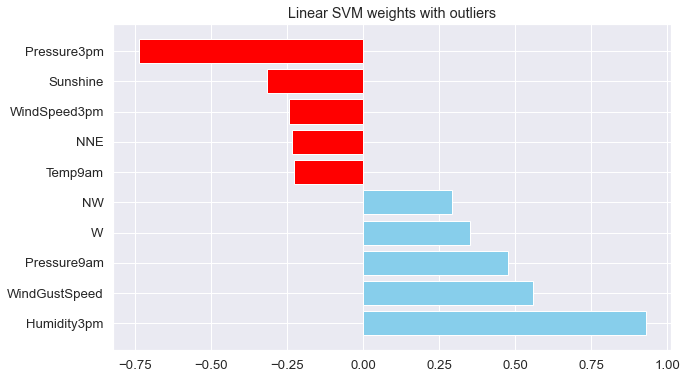

In [124]:
#MOST INFLUENT VARIABLES 
dff=pd.DataFrame(X.columns.tolist())
dff['valori features']=modell1.coef_[0]
dff1=dff.sort_values(by="valori features",ascending=False).reset_index(drop=True)

##most important input variable direction and weights
plt.figure(figsize=(8, 6))
prime_5 = dff1.head(5)
ultime_5 = dff1.tail(5)

df_sel = pd.concat([prime_5, ultime_5])


plt.figure(figsize=(10, 6))

colori = ['skyblue'] * 5 + ['red'] * 5
plt.barh(df_sel.iloc[:,0], df_sel.iloc[:,1], color=colori)
plt.title("Linear SVM weights with outliers")

#### DATASET WITHOUT OUTLIERS IN THE TRAINING 

In [125]:
#SELECTED MODEL (training set without outliers)
modell2=SVC(kernel="linear",C=0.316228 )
modell2.fit(X_Nest1,y_Nest1)
y_pred2=modell2.predict(X_Sep)

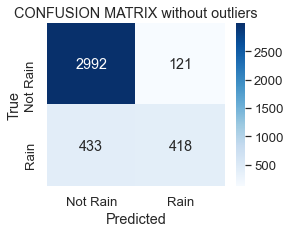

In [126]:
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix(y_Sep,y_pred2), annot=True, fmt='g', cmap='Blues', xticklabels=['Not Rain', 'Rain'], yticklabels=['Not Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CONFUSION MATRIX without outliers')
plt.show()

In [127]:
#PRECISION NOT RAIN, PRECISION RAIN, ACCURACY
round(precision_score(y_Sep,y_pred2, pos_label='No'),3),round(precision_score(y_Sep,y_pred2,pos_label="Yes"),3),round(accuracy_score(y_Sep,y_pred2),3)

(0.874, 0.776, 0.86)

In [128]:
#HYPERPLANE COEFFICIENTS FOR EACH VARIABLE
modell2.coef_

array([[-0.02682987,  0.16950535, -0.00762511,  0.05049232, -0.28619864,
         0.55513548, -0.02486408, -0.24842356, -0.05979211,  0.92507095,
         0.46145455, -0.71720311, -0.11306493,  0.08147364, -0.19162932,
         0.07613896, -0.19666737, -0.07057003, -0.03387983, -0.03651668,
         0.14094503,  0.10665349, -0.07545629, -0.0418669 , -0.20873173,
         0.05265149,  0.37312752,  0.17364149,  0.00729827,  0.12561117,
        -0.20142653, -0.1148131 , -0.14591794,  0.14591794,  0.02275811,
         0.02850706, -0.01212147, -0.0391437 , -0.00911886,  0.10408978,
        -0.0575711 , -0.03739982]])

Text(0.5, 1.0, 'Linear SVM weights without outliers')

<Figure size 576x432 with 0 Axes>

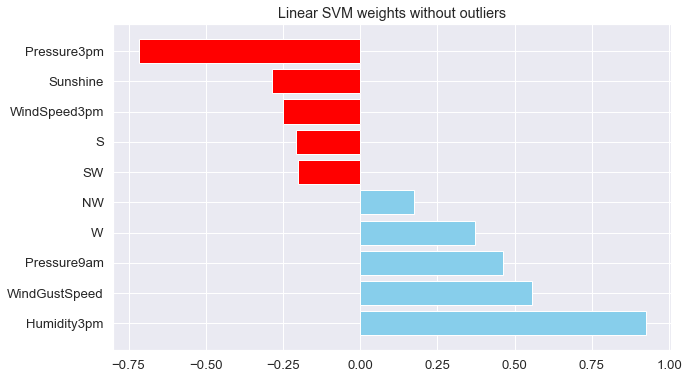

In [129]:
#MOST INFLUENT VARIABLES
dff2=pd.DataFrame(X.columns.tolist())
dff2['valori features']=modell2.coef_[0]
dff2=dff2.sort_values(by="valori features",ascending=False).reset_index(drop=True)
##most important input variable direction and weights
plt.figure(figsize=(8, 6))
prime_52 = dff2.head(5)
ultime_52 = dff2.tail(5)

df_sel2 = pd.concat([prime_52, ultime_52])

plt.figure(figsize=(10, 6))

colori = ['skyblue'] * 5 + ['red'] * 5
plt.barh(df_sel2.iloc[:,0], df_sel2.iloc[:,1], color=colori)
plt.title("Linear SVM weights without outliers")